# OFDM Fundamentals

This notebook introduces the fundamental theory of Orthogonal Frequency Division Multiplexing (OFDM). OFDM is a form of digital multi-carrier modulation that has been adopted as the basis of several modern wireless standards such as Wi-Fi, 4G and now 5G.  

## Aims 

* Provide an overview of the OFDM transmission process
* Discuss the role of the IFFT & FFT in OFDM  
* Provide a brief summary of multipath channels
* Demonstrate the purpose of the Cyclic Prefix 
* Introduce the one-tap equaliser
* Provide an overview of an OFDM transceiver

##  Table of Contents 

* [1. Introduction](#introduction)
* [2. OFDM Transmitter](#ofdmtx)
   * [2.1 Baseband Symbol Generation](#baseband)
   * [2.2 Serial to Parallel Converter](#s2p)
   * [2.3 Sub-carrier Modulation](#scmod)
   * [2.4 Sub-carrier addition](#scadd)
   * [2.5 Modulation using the IFFT](#IFFT)
* [3. The Multipath Channel](#multipath)
   * [3.1 Effect of Multipath Channel on OFDM Signals](#mpofdm)
* [4. The Cyclic Prefix](#cp)
  * [4.1 One Tap Equaliser](#onetap)
* [5. Updated OFDM Transmitter](#ofdmtxupdate)
* [6. Wireless Channel](#wirelesschan)
* [7. OFDM Receiver](#ofdmrx)

## 1. Introduction <a class="anchor" id="introduction"></a>

In this notebook, the fundamentals of OFDM are introduced. OFDM is a digital multi-carrier modulation method used in several wireless communications standards, such as the IEEE 802.11 family (Wi-Fi), 4G Long Term Evolution (LTE) and most recently 5G New Radio (NR). 

In OFDM, a high rate symbol stream (QPSK, QAM etc.) is transmitted as a sum of several parallel low rate streams, that each modulate a different orthogonal sub-carrier. This approach leads to a significantly simplified equalisation processs in the receiver and the use of orthogonal sub-carriers produces a very spectrally efficient transmission.  

The orthogonal modulation and demodulation processes are equivalent to the Inverse Discrete Fourier Transform (IDFT) and DFT respectively, allowing OFDM to be implemented efficiently using Fast Fourier Transform (FFT) algorithms. The use of independent sub-carriers also leads to a convenient multiple access scheme, where the available sub-carriers are shared among several different users.

## 2. OFDM Transmitter <a class="anchor" id="ofdmtx"></a>

In this section, we will go through each step of the OFDM moudlation process. A high level overview of an OFDM transmitter is shown below:

<a class="anchor" id="fig-2.1"></a>
<figure>
<img src="images/ofdm_tx_1 copy.svg" style="width: 900px;"/> 
    <figcaption><b>Figure 2.1: OFDM Transmitter</b></figcaption>
</figure>     

In [157]:
# Import necessary libraries 
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import signal

# Import helper function
from helper_functions import symbol_gen, awgn, psd, \
frequency_plot, scatterplot, calculate_evm

To begin with, let us define the modulation scheme and symbol rate of the initial high rate symbol stream:

In [158]:
mod_scheme = '16-QAM' # Modulation scheme 
fs = 20e6 # Initial symbol rate

In OFDM systems, the baseband modulation scheme is Quadrature Amplitude Modulation (QAM). It can vary from BPSK at the lowest to 1024-QAM or higher in the latest standards. Using higher levels of QAM allows a greater amount of data to be transmitted within a fixed bandwidth. The rate of the initial symbol stream is denoted by $f_{s}$, since it is equivalent to the sampling rate in OFDM systems. We can now define the number of sub-carriers: 

In [159]:
N = 64 # No. of sub-carriers 
deltaf = fs/N # Sub-carrier spacing

The number of sub-carriers is chosen such that the channel frequency repsonse is effectively constant across the sub-carrier bandwidth. This facilitates simplified frequency domain equalisation of each sub-carrier in the receiver. The process of equalising several parallel sub-carriers in the frequeny domain is much more computationally efficient than the time domain equalisation traditionally used in single carrier systems.

Notice that the number of sub-carriers has been set to a power of 2. This is because later we'll show that OFDM is implemented using FFT algorithms, which use power of 2 lengths. The sub-carrier spacing, $\Delta f$, is set to the minimum spacing required to achieve orthogonality between sub-carriers. This will be explained in more detail later. Orthogonality is useful because it allows tight overlap of sub-carriers in frequency, mitigating the need for guard bands to keep the sub-carriers separated. This  leads to a greater level of spectral efficiency than can be achieved with generic Multi-Carrier Modulation (MCM). Moreover, it removes the need for expensive bandpass filters to recover the sub-carriers in the receiver. 

### 2.1 Baseband Symbol Generation <a class="anchor" id="baseband"></a>

With reference to the diagram above, we will now explain and demonstrate the process of generating an OFDM signal. The first step is to generate the underlying data symbols; either BPSK, QPSK or 16-QAM in this example. As indicated by the diagram, we would normally start with the data bits and subsequently map to symbols (BPSK,QPSK...) but we will skip this step here.   

In [160]:
n_ofdm = 500 # No. of OFDM symbols
nsym = n_ofdm * N # No. of data symbols 

# Generate BPSK, QPSK or 16-QAM symbols
data_serial = symbol_gen(nsym,mod_scheme)

The number of data symbols (BPSK, QPSK..) is determined by the number of OFDM symbols we want to generate. An OFDM symbol is formed from a block of $N$ contiguous data symbols. Each data symbol in the block modulates a different sub-carrier and the resulting signals are then added together to create the OFDM symbol. The final OFDM signal consists of a series of OFDM symbols. 

### 2.2 Serial to Parallel Converter <a class="anchor" id="s2p"></a>

The process of mapping blocks of symbols to sub-carriers is equivalent to serial to parallel conversion. The symbols modulating each sub-carrier are separated by a gap of $N$ symbols in the original symbol stream (in practice this is lower due to the use of pilots and null sub-carriers). Hence, the symbol rate on each sub-carrier is $N$ times lower. The serial to parallel conversion is shown below:

In [161]:
# Matrix to hold parallel low rate data streams
data_parallel = np.zeros((N,n_ofdm),np.complex64)  
j= 0

# Serial to Parallel converter
for i in range(n_ofdm):
    data_parallel[:,i] = data_serial[j:j+N]
    j = j + N

### 2.3 Sub-carrier Modulation <a class="anchor" id="scmod"></a>

The parallel low rate streams then modulate each of the sub-carriers. In this example, all sub-carriers are being used to transmit data symbols. However, in real systems, pilot sub-carriers are embedded in the OFDM symbol for synchronisation and channel estimation tasks in the receiver. Also, the outer sub-carriers (i.e. those closest to the edges of the transmit frequency band) are often left blank to mitigate the need for very expensive analogue anti-imaging and and anti-alisaing filters in the transmitter and receiver respectively. These are known as null sub-carriers. 

The construction of an OFDM symbol can be expressed mathematically as: 

$$x[n]=\sum_{k=0}^{N-1} X[k]e^{j2 \pi k (\Delta f / f_{s}) n},$$

where $x[n]$ is the OFDM signal, $X[k]$ is the $k^{th}$ input symbol, $\Delta f$ is the sub-carrier spacing, $\textit{n}$ is the sample index and $\textit{k}$ is the sub-carrier index. We can now generate the sub-carriers:  

In [162]:
sc = np.zeros((N,N),np.complex64) # Matrix to hold sub-carriers 
k = np.arange(N) # Define sub-carrier indices i.e. [0,1....N-1]
n = k # Discrete time index  

# Generate sub-carriers  
for i in range(N):
    sc[i,:] = np.exp(1j*2*math.pi*k[i]*(deltaf/fs)*n)

The sub-carriers are then modulated by the data symbols: 

In [163]:
# Modulate sub-carriers with data symbols   
sc_mod = np.zeros((N,n_ofdm*N),np.complex64)
j = 0

for i in range(n_ofdm):
    sc_mod[:,j:j+N] = sc * data_parallel[:,i][:, np.newaxis]
    j = j + N

Having modulated the individual sub-carriers with the different lower rate data streams, we can now plot the spectra of the individual sub-carriers. Before that though, we should review some theory to understand what to expect. 

OFDM implicitly uses a rectangular pulse shape with a duration of $\textit{T}$ seconds, where $\textit{T}$ is equal to the OFDM symbol period. Since the symbol rate on each sub-channel is $\textit{N}$ times smaller than the initial symbol rate, $f_{s}$, it follows that

$$ T = N T_{s}, $$

where $T_{s}$ is the period of the initial symbol stream or sampling period.   

A rectangular pulse of duration $T$ has a sinc frequency spectrum whose zero crossings occur at $\pm{1/T}$ $\textit{Hz}$, $\pm{2/T}$ $\textit{Hz}$,$\pm{3/T}$ $\textit{Hz}$ and so on... Therefore, if we choose a minumum sub-carrier spacing of $1/T$ $\textit{Hz}$, the centre frequency or maximum effect point of each sub-carrier will correspond to the zero crossings of all other sub-carriers. As a result, the sub-carriers are orthogonal. The sub-carrier spacing is given by:

$$ \Delta f = \frac{1}{T}. $$

Substituting the previous equation for $\textit{T}$ gives: 

$$ \Delta f = \frac{1}{NT_{s}} = \frac{f_{s}}{N}, $$

which explains the choice of sub-carrier spacing made earlier in the notebook. 

In the following code cell, we extract two sub-carriers and plot their Power Specral Densities (PSDs):

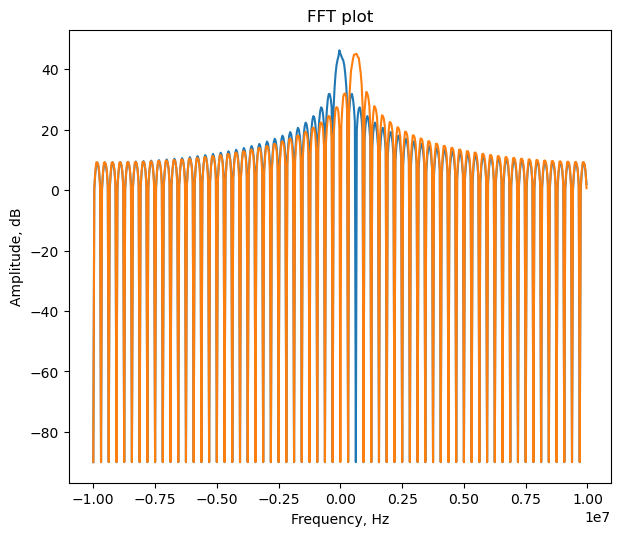

In [164]:
# Extract two sub-carriers and plot together 
sc_1 = sc_mod[0,:] 
sc_2 = sc_mod[2,:]

# Estimate PSDs of sub-carriers 
fft_s = 512
wtype = 'Rectangle' 
overlap = 0
psd_est_1 = psd(sc_1,fft_s,wtype,overlap)
psd_est_2 = psd(sc_2,fft_s,wtype,overlap)

# Convert to dB
epsilon = 1e-9; # Add to avoid divide by zero errors
psd_db_1 = 10 * np.log10(psd_est_1+epsilon) 
psd_db_2 = 10 * np.log10(psd_est_2+epsilon)

# Frequency axis 
freqs = np.linspace(-fs/2,(fs/2 - (fs/fft_s)), fft_s) 

# Plot PSDs
fig=plt.figure(figsize=(7,6), dpi=100)
frequency_plot(freqs, np.fft.fftshift(psd_db_1), ax=None)
frequency_plot(freqs, np.fft.fftshift(psd_db_2), ax=None)

As expected, it can be observed that the sub-carriers have a sinc frequency spectrum. Also, due to the choice of spacing, the centre of each sub-carrier correpsonds to the zero crossing of the other sub-carrier. 

It can also be observed that there is interference between the sub-carriers at other frequencies which may seem at first glance to be problematic. However, in the receiver, we sample the sub-carrier at its maximum effect point, where the interference from the other sub-carriers is zero. This means that the interference at other frequencies is irrelevant. 

To summarise, the orthogonality property enables the data to be recovered perfectly depsite the fact that the sub-carriers are interfering with one another (just not at the maximum effect points). This mitigates the need for guard bands to keep the sub-carriers separated and expensive bandpass filters to recover each sub-carrier at the receiver. This makes OFDM a very efficient form of MCM.  

In practice, channel and hardware indcued impairments will cause the sub-carrier maximum effect points to drift from the ideal frequencies, leading to Inter Carrier Interference (ICI). This manifests as a form of additive noise that cannot be removed. As a result, we must ensure that ICI is minimised as much as possible.   

### 2.4 Sub-carrier Addition <a class="anchor" id="scadd"></a>

Finally, the sub-carriers are summed to create the OFDM symbol: 

In [165]:
ofdm_data = np.sum(sc_mod,0,np.complex64)/N

### 2.5 Modulation using the IFFT <a class="anchor" id="IFFT"></a>

In practice, the orthogonal modulation process shown above requires $\textit{N}$ complex oscillators at both transmitter and receiver. This makes this form of multi-carrier modulation prohibitivley costly as $\textit{N}$ gets larger. However, this cost can be reduced signiciantly if we realise that the modulation and demodulation processes are equivalent to an IDFT and DFT respectively. As such, we can implement OFDM using FFT algorithms, which are much more computationally efficient. 

As it turns out, it is quite easy to prove that the OFDM modulation process is equivalent to an IDFT. Recall, that the sub-carrier spacing for OFDM, $\Delta_{f}$, is given by: 

$$\Delta_{f} = \frac{f_{s}}{N}.$$

Therefore, if we substitute this equation into our subcarrier modulation equation, it reduces to:

$$x[n]=\sum_{k=0}^{N-1} X[k]e^{j2 \pi k n / N},$$

which is the equation for the IDFT without the $1/N$ scaling factor. 

We can now compare the OFDM symbols generated using the orthogonal modulation process with the symbols generated by the IFFT to show that they are equivalent:  

In [166]:
# Define function to modulate using IFFT 
def ifft_mod(symbols,N):
    ofdm_data = np.fft.ifft(symbols,N)
    return ofdm_data

#  Generate OFDM symbols using IFFT modulation   
ofdm_data_ifft = np.zeros(n_ofdm*N,np.complex64)
j = 0

for i in range(n_ofdm):    
    ofdm_data_ifft[j:j+N] = ifft_mod(data_serial[j:j+N],N)
    j = j + N  

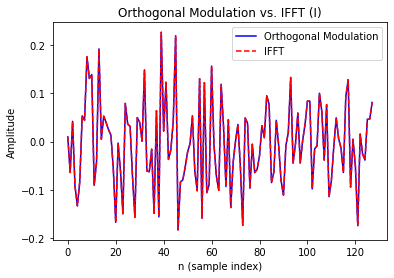

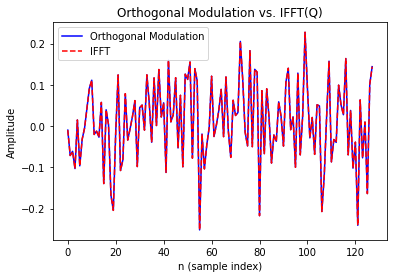

In [167]:
# Compare OFDM symbols generated using orthogonal modulation and IFFT respectively
plt.plot(ofdm_data[0:(2*N)].real,'b')
plt.plot(ofdm_data_ifft[0:(2*N)].real,'--r')
plt.title('Orthogonal Modulation vs. IFFT (I)')
plt.xlabel('n (sample index)')
plt.ylabel('Amplitude')
plt.legend(('Orthogonal Modulation','IFFT'))

plt.figure(2)

plt.plot(ofdm_data[0:(2*N)].imag,'b')
plt.plot(ofdm_data_ifft[0:(2*N)].imag,'--r')
plt.title('Orthogonal Modulation vs. IFFT(Q)')
plt.xlabel('n (sample index)')
plt.ylabel('Amplitude')
plt.legend(('Orthogonal Modulation','IFFT'))

The plots show that the data produced using orthogonal modulation is equivalent to the IFFT. We can also confirm this by measuring the Mean Square Error (MSE) between the data streams:   

In [168]:
mse = np.mean(abs(ofdm_data-ofdm_data_ifft)**2)
mse

3.5007734e-16

## 3. The Multipath Channel <a class="anchor" id="multipath"></a>

In a typical wireless channel, the transmitted signal is reflected off objects (buildings, vehicles, foliage etc) in the signal path, leading to several delayed and attenuated copies of the signal arriving at the receiver. The constructive and destructive interference of the multipath components lead to fading of the received signal. The fading effect is frequency selective i.e. different frequencies experience different amounts of fading. 

The channel is characterised by its delay spread, $d_{s}$, which is the difference in time between the first and last multipath arrivals. In the frequency domain, the channel is characterised by its coherence bandwidth, $B_{c}$, which is the range of frequencies over which the fading effect is approximately constant. The two quantities are approximately inversely proportional: 

$$d_{s} \approx \frac{1}{B_{c}}.$$

Depending on the characteristics of the transmitted signal, the channel can be classified as a flat fading or frequency selective fading channel. 

The channel is flat fading when the symbol period is long compared to the channel delay spread, 

$$ T_{sym} \gg d_{s}, $$

where $T_{sym}$ represents the symbol period. In the frequency domain, the signal bandwidth is small compared to the coherence bandwidth, 

$$ B \ll B_{c},$$

where $B$ is the signal bandwidth. A flat fading channel is relatively simple to equalise or compenstate for and there is limited Inter Symbol Interference (ISI).

Conversely, the channel is experienced as frequency selective if the symbol period is small compared to delay spread, 

$$ T_{sym} \ll d_{s}, $$

and the signal bandwidth is large compared to the coherence bandwidth, 

$$ B \gg B_{c}. $$

The ISI is more severe in a frequency selective channel and it is more challenging to equalise. 

### 3.1 Effect of Multipath channels on OFDM signals <a class="anchor" id="mpofdm"></a>

In OFDM, we choose the number of sub-carriers such that their bandwidth much smaller than $B_{c}$. As such, each sub-carrier experiences a flat fading channel. This leads to the "one tap" equaliser, which reduces the equalisation process to a single complex scaling per sub-carrier. The one tap equaliser is a major advanatage of OFDM. In addition, the use of orthogonal sub-carriers increases the spectral efficiency of the transmission. 

However, in practice, the multipath channel violates sub-carrier orthogonality and introduces Inter Symbol Interference (ISI), meaning these advantages are lost. 

A multipath channel can be modelled as a Finite Impulse Response (FIR) filter, since the output signal is equivalent to the convolution of the input signal with the channel impulse response. Each filter coefficient represents a single resolvable multipath component and the length of the filter is dictated by the channel delay spread i.e. the time difference between the first and last multipath arrivals. 

Let us consider a simple three tap channel filter as illustrated below:

<a class="anchor" id="fig-3.1"></a>
<figure>
<img src="images/filter copy.svg" style="width: 550px;"/> 
    <figcaption><b>Figure 3.1: Multipath Channel Filter</b></figcaption>
</figure>     

Note this is not an accurate representation of a real channel, but is sufficient for understanding the effects of multipath on OFDM signals.  

Recall that the OFDM symbol is simply composed of a sum of amplitude and phase modulated complex sinusoids or sub-carriers (formed using IFFT). In order to illustrate the effects of multipath on OFDM, we will consider only a single sub-carrier. The effects described will apply equally to all other sub-carriers. Let us concentrate on the sub-carrier at $k = 1$ as below:

In [169]:
# Sub-carrier at k = 1 or fs/N Hz
n = np.arange(64)
k = 1
sc = np.exp(1j*2*math.pi*k*n/N) 

Now let's extract the real or in-phase component of the sub-carrier and plot it:

Text(0, 0.5, 'Amplitude')

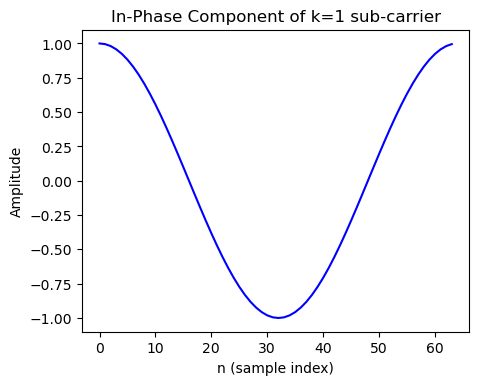

In [170]:
# Extract In-Phase component
sc_real = sc.real

fig=plt.figure(figsize=(5,4), dpi=100)
plt.plot(sc_real,'b')
plt.title('In-Phase Component of k=1 sub-carrier')
plt.xlabel('n (sample index)')
plt.ylabel('Amplitude')

As can be observed, the sub-carrier is a perfect cosinusoid and has one full period within $T$ seconds or $N$ samples i.e. the OFDM symbol period. As we know, in this sub-carrier would be amplitude and / or phase modulated depending on the underlying modulation scheme e.g. QPSK, 16-QAM. However, we will leave it unmodulated at the present time. 

The signal can now be passed through the multipath channel that we showed previously, 

In [171]:
# Multipath channel 
h = np.array([0.9,0.3,0.05])
sc_filt = np.convolve(sc_real, h)

and plot the filtered sub-carrier..

Text(0, 0.5, 'Amplitude')

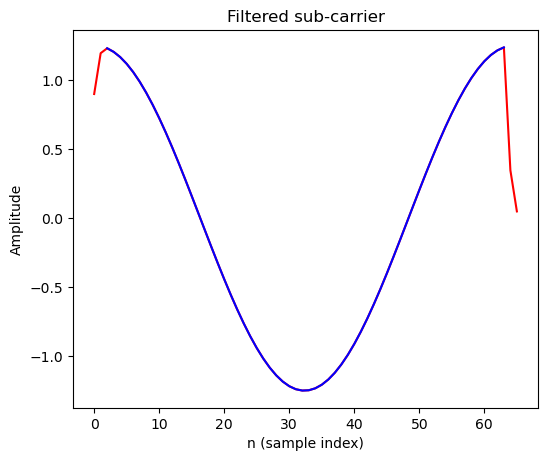

In [172]:
fig=plt.figure(figsize=(6,5), dpi=100)
plt.plot(sc_filt,'r')
xvals = np.arange(66)
xvals = xvals[2:64]
plt.plot(xvals,sc_filt[2:64],'b')

plt.title('Filtered sub-carrier')
plt.xlabel('n (sample index)')
plt.ylabel('Amplitude')

As we know, the output signal is the convolution of the input signal and the channel response. From our DSP knowledge, we know that convolving a 64 sample sequence with a 3 sample sequence leads to a 66 sample sequence. We can confirm this below:

In [173]:
len(sc_filt)

66

Now let's concentrate on the first 2 samples of the output sequence, which are plotted in red in the above figure. These arise as a result of the initial transient before the filter (or channel) is fully occupied by signal components. We can confirm that for our 3 tap filter, the initial transient is 2 samples long. 

The initial transient is problematic because it means that the sub-carrier is no longer sinusoidal within the window of $T$ seconds or $N$ samples. This also applies to the other sub-carriers within the OFDM symbol. The initial transient distorts the sinusodial shape of the sub-carriers, thus violating the orthogonality between them. It is also necessary for the amplitude and phase of each sub-carrier to remain constant over a duration of $T$ seconds to maintain orthogonality. However, this is no longer the case - its actually only constant over a window of 62 samples or $\approx 0.9T$ seconds 

Now, let's focus on the last 2 samples of the filtered sub-carrier, which are also plotted in red. These samples are caused by the final transient as the signal exits the filter (or channel). The final transient is also 2 samples long. The final transient is an issue because it causes interference with the same sub-carrier in the subsequent OFDM symbol. This is due to the fact that the second symbol is sent immediately after the first symbol and so on i.e there is no guard interval between symbols (yet). This phenomenon is known as ISI and causes a severe performance degradation.

Clearly, this discussion has demonstrated that multipath channels have a detrimental effect on OFDM signals. This would appear to mitigate any potential advantages of using OFDM. However, these issues can be resolved by the addition of a special guard interval called the Cyclic Prefix (CP). 

## 4. The Cyclic Prefix <a class="anchor" id="cp"></a>

The CP is formed by extracting a portion of the end of the OFDM symbol and appending it to the front. The CP is made to be longer than the expected delay spread. This is possible because the OFDM symbol period is much greater than the delay spread.  

In order to demonstrate the addition of a CP, we will again consider the in-phase component of a single sub-carrier.

Refrerring to the channel filter above, we can see that the first multipath component arrives immediately and the last multipath component arrives 2 samples later, meaning the delay spread is equal to 2 sample periods. We will therefore choose a CP length of 4. In the following code cell, we will append the CP samples and plot the resulting waveform:

Text(0, 0.5, 'Amplitude')

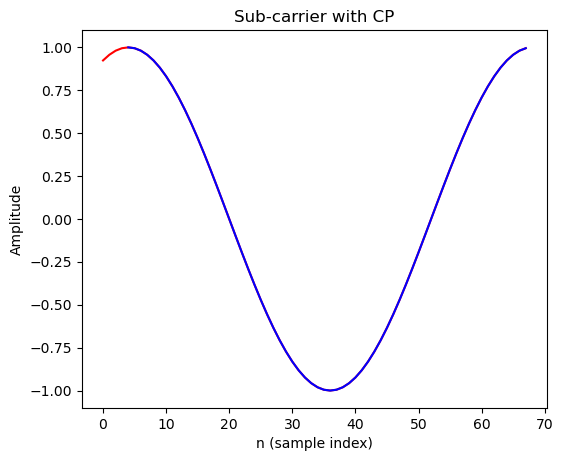

In [174]:
# Extract CP samples 
cp = sc_real[60:64]

# Append to front of sub-carrier 
sc_cp = np.concatenate((cp, sc_real))

# Plot resulting waveform 
fig=plt.figure(figsize=(6,5), dpi=100)
plt.plot(sc_cp,'r')
xvals = np.arange(68)
xvals = xvals[4:68]
plt.plot(xvals,sc_cp[4:68],'b')

plt.title('Sub-carrier with CP')
plt.xlabel('n (sample index)')
plt.ylabel('Amplitude')

In the above plot, the CP samples are highlighted in red. The first thing we notice is that there is no discontinuity between the CP and the sub-carrier. This is due to the fact that there is exactly one period of the sub-carrier in the OFDM symbol period i.e. 64 samples in this example. There is also no discontinuity for the other sub-carriers because they all have an integer number of periods within the OFDM symbol period. This is benefcial since it prevents generation of spurious high frequency components due to discontinuities between the symbol and the gurad interval. However, ultimately, there is still discontinuities between the OFDM symbols themselves. These discontinuities are addressed using windowing techniques.   

The full OFDM symbol (including CP) can be formed by adding CPs to each individual sub-carrier as above and summing the resulting waveforms together. This is equivalent to first using the IFFT to generate the sum of modulated orthogonal sub-carriers (OFDM symbol) and then adding a CP at the beginning of the symbol. As we've learned, the latter approach is used in practice. 

Having described the mechanics of adding the CP, we can now demonstrate how it addresses the problems caused by the multipath channel. In order to do this, we will pass the sub-carrier with CP through the channel and plot the output signal: 

In [175]:
# Pass sub-carrier with CP through channel filter 
sc_filt_cp = np.convolve(sc_cp, h)

With the addition of a 4 sample CP, the sub-carrier is now 68 samples long. The output signal is 70 samples long as confirmed below: 

In [176]:
len(sc_filt_cp)

70

We can now plot the received waveform:

Text(0, 0.5, 'Amplitude')

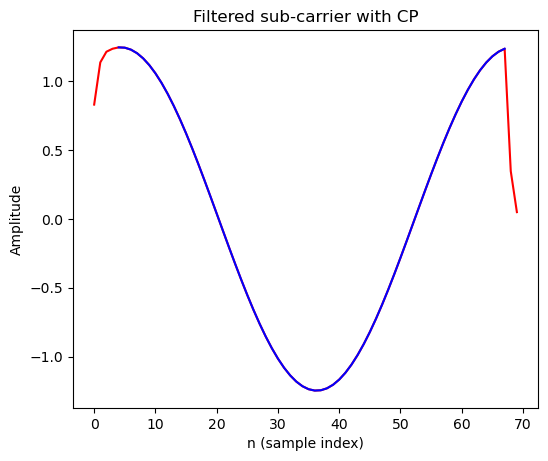

In [177]:
# Plot received waveform 
fig=plt.figure(figsize=(6,5), dpi=100)
plt.plot(sc_filt_cp,'r')
xvals = np.arange(70)
xvals = xvals[4:68]
plt.plot(xvals,sc_filt_cp[4:68],'b')

plt.title('Filtered sub-carrier with CP')
plt.xlabel('n (sample index)')
plt.ylabel('Amplitude')

Ok, let's look at the first 4 output samples highlighted in red. These correspond to the CP portion of the symbol since they are transmitted first. Recall that the initial transient of the multipath channel was 2 samples long and that the CP is 4 samples long. This means that the CP is is "on" or being tranmitted during the initial transient of the multipath channel and thus the CP is able to absorb it. Note the CP is slightly longer than necessary to absorb the initial transient. However, it is normal for the CP to be longer than the delay spread of the channel. 

Now, let's focus on the blue portion of the output waveform. This has the desired sinusoidal shape across a duration of 64 samples i.e. the OFDM symbol period. Therefore, the CP preserves the sinusoidal shape of the sub-carriers when the signal is passed through the multipath channel and thus their orthoginality is maintained. Furthermore, the amplitude and phase of each sub-carrier is constant over the window of $T$ seconds or $N$ samples as required. 

Finally, we have a further 2 samples highlighted in red. As before, these correspond to the final transient of the channel. Although it is not shown explicitly, the final transient occurs during the CP of the next symbol. Therefore, the CP of the next symbol absorbs ISI from the current symbol. As long as the CP is longer than delay spread, the CP will completely eliminate ISI. The CP will absorb a combination of the initial transient of the current symbol and the final transient of the previous symbol and thus resolves the issues discussed earlier.

### 4.1 One Tap Equaliser <a class="anchor" id="onetap"></a>

In addition to resolving the above issues related to multipath channels, the CP has one other important role to play in OFDM systems. Namely, it leads to the so-called one tap equaliser. 

In order to understand this, we need to recall the convolution theorem. The convolution theorem states that linear convolution in time is equivalent to multiplication in frequency. This equivalency can be expressed mathematically as, 

$$ x(t) * y(t) = \mathcal{IF}[\mathcal{F}(x(t)) \mathcal{F}(y(t))]$$

where * denotes convolution, $\mathcal{F}$ is the Fourier Transform and $\mathcal{IF}$ is the Inverse Fourier Transform. In basic terms, this states that the Inverse Fourier transform of the of product of the Fourier transforms of two signals x(t) and y(t) is equivalent to their linear convolution. Notice that the signals we have used are continuous time. 

However, we are interested in discrete time since OFDM is a digital modulation method. In dsicrete time, the convolution theorem is slightly different. In this case, multiplication in frequency is equivalent to periodic or circular convolution in the time domain. Therefore, the covolution theorem for discrete time is re-written as,

$$ x[n] \bigotimes y[n] $$

In circular convolution, the two discrete-time signals being convolved are $N$ periodic i.e. they only have $N$ unique values and repeat after $N$. As such, the convolution is also $N$ periodic. Section needs to be finished. 

## 5. Updated OFDM Transmitter <a class="anchor" id="ofdmtxupdate"></a>

Based on the learning of the previous sections, we can now draw the final OFDM transmitter as follows: 

<a class="anchor" id="fig-5.1"></a>
<figure>
<img src="images/ofdm_tx_2 copy.svg" style="width: 900px;"/> 
    <figcaption><b>Figure 5.1: Updated OFDM Transmitter</b></figcaption>
</figure>    

As we can see, the data bits are first mapped to symbols (BPSK, QPSK, 16-QAM..etc). The symbols are then grouped into blocks of $N$ and an IFFT is peformed to produce the OFDM symbols. Finally, a CP is added to each symbol and the signal is transmitted. 

We have already completed the first two steps in the  OFDM transmitter section. Therefore, all that remains is to add the CP between symbols. The CP length is set to 1/4 of the OFDM symbol length i.e. 16 samples. These means the full symbol duraton including CP is 80 samples.  

In [178]:
# Define function to add CP 
def add_cp(use_symb,N,cp_len):
    
    #Extract CP
    cp = use_symb[N-cp_len:N:1]
    
    # Concatenate CP and symbol 
    ofdm_symb = np.concatenate((cp,use_symb))
    
    return ofdm_symb

cp_len = N // 4 # CP length is 1/4 of symbol period

# Add CP to each of the ofdm symbols 
txSig = np.zeros(n_ofdm*(N+cp_len),np.complex64)
j = 0
k = 0 

for i in range(n_ofdm):    
    txSig[k:(k+N+cp_len)] = add_cp(ofdm_data_ifft[j:j+N],N,cp_len)
    j = j + N  
    k = k + N + cp_len 

## 6. Wireless Channel <a class="anchor" id="wirelesschan"></a>

At this stage, we will pass the OFDM signal through the multipath channel we defined earlier and add Additive White Gaaussian Noise (AWGN). The power of the noise is determined by the Signal to Noise ratio (SNR), secified in dB. 



In [179]:
SNR = 35 # Desired SNR (dB) 
rxSig = awgn(txSig,SNR)

## 7. OFDM Receiver <a class="anchor" id="ofdmrx"></a>

In the receiver, the underlying data symbols (BPSK,QPSK,QAM etc) are recovered using the FFT (since IFFT was used for modulation). The receiver processing is illustrated below: 

<a class="anchor" id="fig-7.1"></a>
<figure>
<img src="images/ofdm_rx copy.svg" style="width: 900px;"/> 
    <figcaption><b>Figure 7.1: OFDM Receiver</b></figcaption>
</figure>

In a practical receiver, we must first perform timing synchronisation to find the location of the OFDM symbols in the received signal. In this example, we know the exact positioning of the OFDM symbols in the received signal. In addition, frequency synchronisation is required to correct for oscillator offsets and Doppler shifts which cause a loss of orthogonality. Before the FFT, we discard the CP as it does not contain any information.  

In [180]:
# Function to demodulate OFDM 
def ofdm_demod(ofdm_rx,N,cp_len):
    
    # Extract useful OFDM symbol 
    ofdm_u = ofdm_rx[cp_len:(N+cp_len)]
    
    # Perform FFT 
    data = np.fft.fft(ofdm_u,N)
    
    return data

# Recover data symbols
data_rx = np.zeros(n_ofdm*N,np.complex64)
j = 0
k = 0 

for i in range(n_ofdm):
    data_rx[j:j+N] = ofdm_demod(rxSig[k:(k+N+cp_len)],N,cp_len)
    j = j + N
    k = k + N + cp_len 

Having removed the CP and performed FFT demodulation, we  can now plot the received BPSK or QPSK constellations:

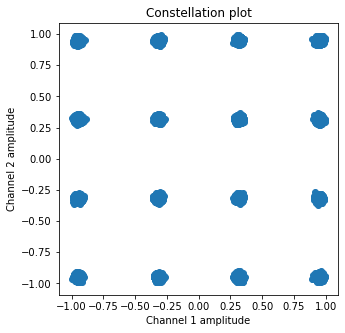

In [181]:
# Plot received constellation 
scatterplot(data_rx.real,data_rx.imag,ax=None)

In addition to viewing the received constellation, signal quality can be measured quantitatively using Error Vector Magnitude (EVM), as described in the notebook on baseband modulation.   

In [182]:
# Calculate and print EVM
print("EVM: {:.2f}%".format(calculate_evm(data_serial, data_rx)))

EVM: 1.78%
